<a href="https://colab.research.google.com/github/r-doz/PML2025/blob/main/./07_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 7: Markov Chain Monte Carlo

This notebook is a revisitation of Ginevra Carbone's work

Suppose you wish to draw samples from a posterior distribution $p(\theta|x)$ and that the computation of the normalization factor 

$$p(x) = \int_\theta p(x|\theta) p (\theta) d \theta$$ 

is intractable, due to the high dimensionality of the problem. 

MCMC is a class of algorithms that allow to perform sampling from the **unkown probability distribution** $p(\theta|x)$,  whose density is proportional to the **known unnormalized factor** $p(x|\theta) p (\theta)$.

The basic idea is that of building a Markov chain that has the desired distribution as its equilibrium distribution. This way, one can obtain a sample of the desired distribution by recording states from the chain and the more steps that are included, the more closely the distribution of the sample matches the desired distribution $p(\theta|x)$.


## Metropolis Hastings from scratch

Assume that we want to sample from a multimodal distribution of which we know only the unnormalized distribution, which is a 1-D Gaussian Mixture. For example, consider the unnormalized probability density function $\tilde{p}(x)$ defined as a mixture of three Gaussian distributions:

$$
\tilde{p}(x) = \mathcal{N}(x; 0, 1) + \mathcal{N}(x; 5, 3) + \mathcal{N}(x; 10, 2)
$$

This distribution is not normalized, and our goal is to sample from it using the Metropolis-Hastings algorithm.

We use a proposal distribution $q(y \mid x)$ defined as a Gaussian centered at the current state $x$ with standard deviation $\sigma$:

$$
q(y \mid x) = \mathcal{N}(y; x, \sigma)
$$

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, HMC, NUTS
import torch
import seaborn as sns

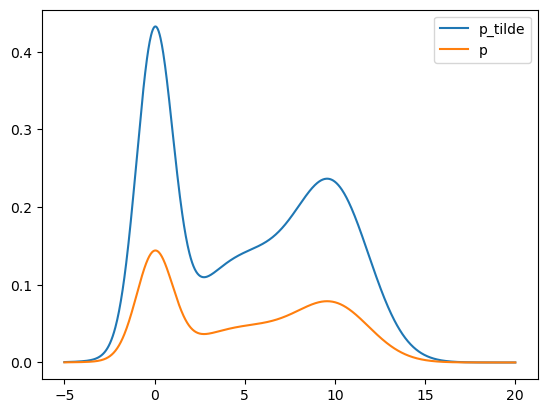

In [67]:
def sample_from_q(x, sigma):
    #your code here
    return np.random.normal(x, sigma)

def q_y_given_x(y, x, sigma):
    #your code here
    return stats.norm(x, sigma).pdf(y)

def p_tilde(x):
    #your code here
    return stats.norm(0, 1).pdf(x) + stats.norm(5, 3).pdf(x) + stats.norm(10, 2).pdf(x)

def metropolis_hastings(n, sigma):
    rejections = 0
    x = np.zeros(n)
    x[0] = np.random.normal(0, 1)
    for i in range(1, n):
        #your code here
        current_x = x[i-1]
        y = sample_from_q(current_x, sigma)

        alpha = min(1., p_tilde(y)/ p_tilde(current_x) * q_y_given_x(current_x, y, sigma) / q_y_given_x(y, current_x, sigma))

        if np.random.rand() < alpha:
            x[i] = y
        else:
            x[i] = current_x
            rejections += 1
    return x, rejections/n


#In this case, we can consider the gaussian mixture where each component has the same weight
def p(x):
    return (stats.norm(0, 1).pdf(x) + stats.norm(5, 3).pdf(x) + stats.norm(10, 2).pdf(x))/3

t = np.linspace(-5, 20, 1000)
plt.plot(t, p_tilde(t), label='p_tilde')
plt.plot(t, p(t), label='p')
plt.legend()
plt.show()
 

Try to consider also a burn-in phase, monitor the rejection rate and plot the rejection rate as a function of the variance.

Rejection rate: 0.1486


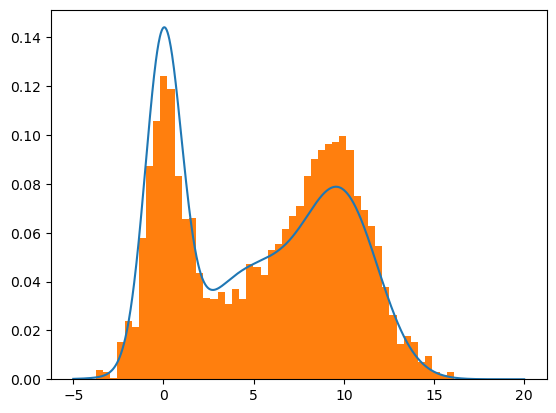

In [68]:
sigma = 1
burn_in = 1000 # number of samples to discard before collecting data
n = 5000
x,r = metropolis_hastings(n, sigma)
x = x[burn_in:]
print('Rejection rate:', r)
plt.plot(t, p(t), label='p(x)')
plt.hist(x, bins=50, density=True, label='samples')
plt.show()

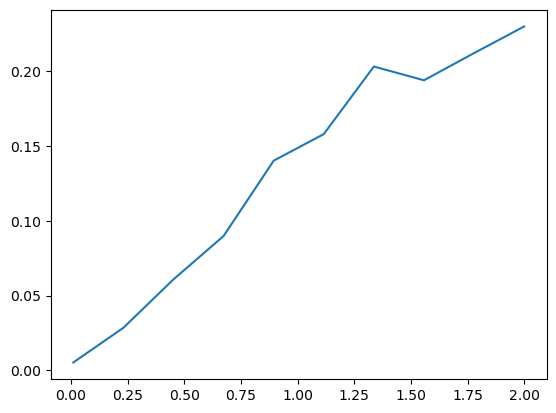

In [69]:
r = []
sigma_range = np.linspace(0.01, 2, 10)
for sigma_i in sigma_range:
    x,r_i = metropolis_hastings(5000, sigma_i)
    r.append(r_i)

plt.plot(sigma_range, r)

### Conditioning in Pyro

Probabilistic programming allows us to condition generative models on observed data and to perform inference on it. In Pyro, we can separate the conditioning step from its evaluation via inference: first write a model and then condition it on many different observations.

We are trying to measure the weight of an object, but we don't have access to the true weights, because the scale is unreliable. 
Instead, we can use a **model of the measurement noise** plus an initial **uncertain guess** (based on some properties of the object) to obtain an **uncertain estimate of the true weight**. 

$$weight \, | \, guess \sim \mathcal{N}(guess, 1)$$

$$ measurement \, | \, guess, weight \sim \mathcal{N}(weight, 0.75^2) $$



In [70]:
def scale(guess=8.5):
    
    # models weight in terms of the initial guess
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))

    # models measurement noise
    measurement = pyro.sample("measurement", dist.Normal(weight, 0.75))
    
    return measurement

Suppose that we observe a measurement of the object corresponding to 9.5 kg. We want to sample from the distribution of the weight given both the observation `measurement = 9.5` and an input knowledge `guess = 8.5`. In other words, we wish to infer the distribution 

$$weight \, | \, guess, measurement=9.5 \sim ?$$

Pyro provides a method called `pyro.condition` that takes as inputs a model and a dictionary of observations and returns a new model which is conditioned on the observations.

In [71]:
# condition the model on a single observation
obs = torch.tensor(9.5)
single_conditioned_scale = pyro.condition(scale, data={"measurement": obs})

`conditioned_scale()` could be equivalently defined by using the `obs` parameter directly inside the model definition:

In [72]:
def conditioned_scale(obs, guess=8.5): 
    weight = pyro.sample("weight", dist.Normal(guess, 1.))
    measurement = pyro.sample("measurement", dist.Normal(weight, 1.), obs=obs)
    return measurement

### Hamiltonian Monte Carlo

Hamiltonian Monte Carlo (HMC) combines an approximate Hamiltonian dynamics simulation and a Metropolis-Hastings acceptance step. It is designed to reduce the problems of *low acceptance rates* and *autocorrelation* bewteen consecutive samples.

HMC introduces an additional *momentum* variable with the aim of favouring the exploration of the typical set, instead of drifting towards the tails or the mode of $\pi$.

### HMC on conditioned scale model

Let's perform inference on the conditioned scale model by using HMC and a few `measurement` observations, with the aim of getting an estimate of the expected weight.

In [73]:
#One chain of MCMC
hmc_kernel = HMC(model=conditioned_scale) # transition kernel
mcmc = MCMC(hmc_kernel, num_samples=500, warmup_steps=100)

`warmup_steps` refers to the **burn-in** period, which is the number of discarded samples before performing the actual sampling of `num_samples` values from the (hopefully) stationary distribution.

`num_chains` is the number of independent MCMC runs, subject to different initializations. Pyro automatically computes them in parallel.

`mcmc.summary()` prints a summary table displaying the diagnostics of posterior samples. In particular, it includes:
- $5\%$ and $95\%$ credibility intervals for the estimates;
- the number of effective samples `n_eff`, representing the number of independent draws from the posterior distribution;
- the split-$\hat{R}$ statistic `r_hat`, which monitors whether the chains have converged to the equilibrium distribution or not. 

Values above 1 for `r_hat` and low values for `n_eff` indicate that some chains have not fully converged. 

In [74]:
# measurement observations
#obs = torch.tensor([8.2, 9.6, 7.8, 9.1])

# suppose the true value is 9:
obs = torch.normal(9.0, 0.75, (20,))
print(obs)

# posteriors 
posterior = mcmc.run(obs=obs)

# dictionary of sampled values
mcmc.summary()

tensor([7.5791, 8.2632, 9.4518, 7.0557, 8.5969, 8.2963, 7.5743, 9.2959, 9.4354,
        9.0154, 9.3147, 8.4178, 8.5221, 9.1486, 9.4882, 8.1876, 9.4098, 9.9978,
        8.9682, 8.5798])


Sample: 100%|██████████| 600/600 [00:02, 249.31it/s, step size=1.25e+00, acc. prob=0.993]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    weight      8.88      0.12      8.87      8.69      9.04      3.32      1.87

Number of divergences: 0


torch.Size([500])


<Axes: ylabel='None'>

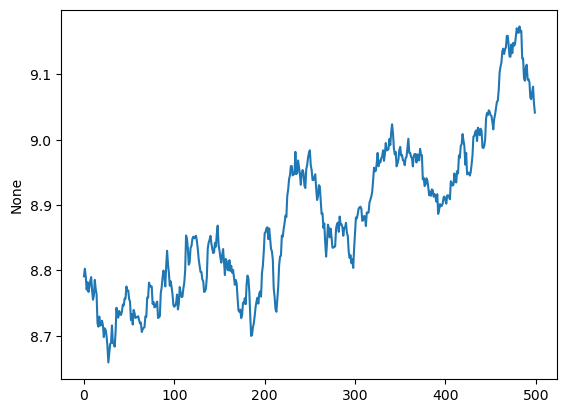

In [75]:
mcmc_samples = mcmc.get_samples()
chain = mcmc_samples["weight"]
n_samples = chain.shape[0]
print(chain.shape)


sns.lineplot(x=range(n_samples), y=chain)

expected weight = 8.880626678466797


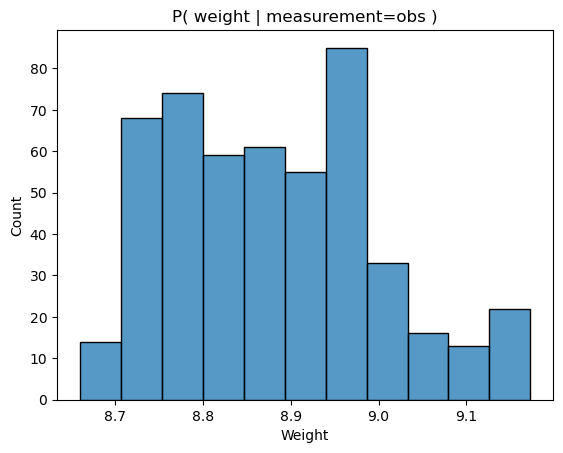

In [76]:
print("expected weight =", mcmc_samples['weight'].mean().item())

sns.histplot(mcmc_samples['weight'])
plt.title("P( weight | measurement=obs )")
plt.xlabel("Weight")
plt.show()

Warmup [1]:   0%|          | 0/600 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/600 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/600 [00:00, ?it/s]

0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


torch.Size([3, 500])


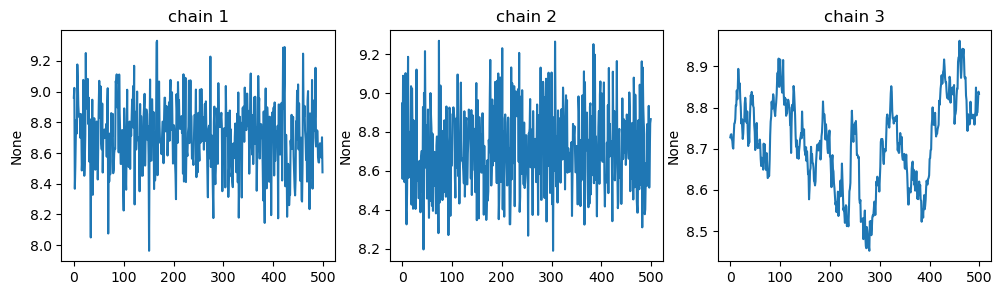

In [77]:
from methods_07 import conditioned_scale_file
# multiple chains
hmc_kernel = HMC(model=conditioned_scale_file) 
mcmc = MCMC(hmc_kernel, num_samples=500, warmup_steps=100, num_chains=3)

posterior = mcmc.run(obs=obs)

# extracting weight samples and grouping them by chains
mcmc_samples = mcmc.get_samples(group_by_chain=True)
chains = mcmc_samples["weight"]

n_chains, n_samples = chains.shape
print(chains.shape)

fig, ax = plt.subplots(1, n_chains, figsize=(12,3))
for i, chain in enumerate(chains):
    sns.lineplot(x=range(n_samples), y=chain, ax=ax[i])
    ax[i].set_title("chain "+str(i+1))

expected weight = 8.713958740234375


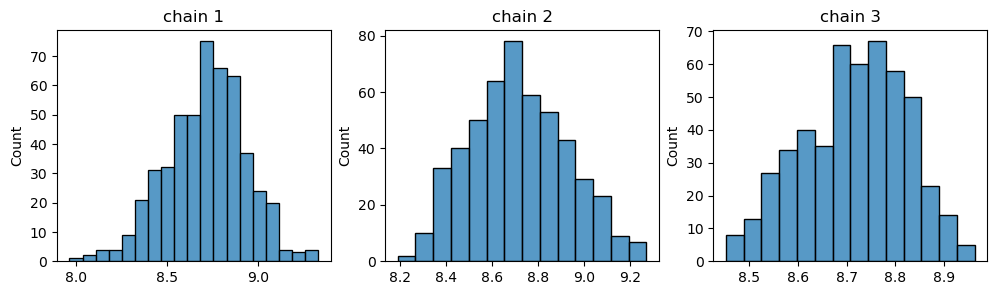

In [78]:
print("expected weight =", mcmc_samples['weight'].mean().item())
fig, ax = plt.subplots(1, n_chains, figsize=(12,3))
for i, chain in enumerate(chains):
    sns.histplot(chain, ax=ax[i])
    ax[i].set_title("chain "+str(i+1))

In [79]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    weight      8.71      0.19      8.72      8.36      8.99    330.75      1.00

Number of divergences: 0


### Eight schools example

Let's consider a hierarchical model of the Eight Schools dataset (Rubin, 1981), taken from chap. 5.5 of Gelman et al. "Bayesian Data Analysis" (2014). 
This study measures the effect of coaching programs on college admission tests and should reflect the knowledge that was acquired by the students from eight different schools.

For each school ($j=1,\ldots,8$) the dataset contains:
- the estimated effect of coaching $y_j$
- the standard error of the effect $\sigma_j$

In [80]:
J = 8
# estimated treatment effect
y = torch.tensor([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
# std of the estimated effect
sigma = torch.tensor([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

Some coaching programs have moderate effects (in the range 18–28 points), most have small
effects (0–12 points), and two have small negative effects.

We are interested in estimating the true effects of coaching $\tau_j$, by using the Bayesian model

\begin{align*}
\mu &\sim \mathcal{N}(0,5)\\
\tau &\sim \text{Half-Cauchy}(0,5)\\
\theta_j &\sim \mathcal{N}(\mu,\tau) \;\; j=1,\ldots,8\\
\tau_j &\sim \mathcal{N}(\theta_j,\sigma_j) \;\;j=1,\ldots,8
\end{align*}


In [81]:
from methods_07 import eight_school_file

HMC solves a two-state differential equation (over the parameters $\theta$ and the momentum $\rho$) using the *Leapfrog integrator* numerical integration algorithm. At each iteration, it takes $L$ discrete steps of some small time interval $\epsilon$.

We are now using **No U-Turn Sampler** (NUTS), a variant of HMC where $L$ and $\epsilon$ are adaptively determined at each iteration, based on the curvature of the log-density: the step size $\epsilon$ gets smaller in areas where the curvature is high, while the number of steps $L$ is large enough for the trajectory to move far through the posterior distribution without turning around.

In [82]:
kernel = NUTS(eight_school_file)
mcmc = MCMC(kernel, warmup_steps=500, num_samples=100, num_chains=4)
mcmc.run(J=J, sigma=sigma, y=y)
mcmc.summary()

Warmup [1]:   0%|          | 0/600 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/600 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/600 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/600 [00:00, ?it/s]

0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      4.25      3.39      4.06     -0.98      9.32    133.68      1.01
       tau      5.54      4.29      4.34      1.08     10.17     55.77      1.03
  theta[0]      7.43      7.53      6.09     -2.99     18.90    122.21      1.00
  theta[1]      5.35      5.59      4.91     -3.26     14.30    154.22      1.01
  theta[2]      3.16      6.14      3.43     -8.43     11.58    159.41      1.01
  theta[3]      4.46      6.11      4.53     -5.99     14.01    270.29      1.00
  theta[4]      2.76      5.00      2.92     -5.10     11.04    221.82      1.01
  theta[5]      3.57      5.60      3.94     -6.06     11.99    249.27      1.02
  theta[6]      7.18      5.44      6.71     -0.77     15.75    180.08      1.00
  theta[7]      5.21      7.32      4.96     -8.09     15.26    283.63      1.01

Number of divergences: 7


We can notice some **divergent transitions**, arising when the simulated Hamiltonian trajectory departs from the true trajectory, potentially reducing the algorithm to a simple random walk. Consequently, if the number of divergent transitions is high, the estimates cannot be trusted.

A **non-centered parametrization** for $\theta_j$ defines the same statistical model, but makes inference more effective when the data is sparse. In fact, it is able to solve the pathologies we encountered in the centered model.

\begin{align*}
\mu &\sim \mathcal{N}(0,5)\\
\tau &\sim \text{Half-Cauchy}(0,5)\\
\nu_j &\sim  \mathcal{N}(0,1) \;\; j=1,\ldots,8\\
\theta_j &= \mu + \tau\, \nu_j  \;\; j=1,\ldots,8\\
\tau_j &\sim \mathcal{N} (\theta_j,\sigma_j) \;\;j=1,\ldots,8
\end{align*}

In [83]:
from methods_07 import eight_schools_noncentered_file

In [84]:
nuts_kernel = NUTS(eight_schools_noncentered_file)
mcmc = MCMC(nuts_kernel, warmup_steps=500, num_samples=100, num_chains=4)
mcmc.run(J=J, sigma=sigma, y=y)
mcmc.summary()

Warmup [1]:   0%|          | 0/600 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/600 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/600 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/600 [00:00, ?it/s]

0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      4.70      3.35      4.88     -1.16      9.87    356.20      1.00
     nu[0]      0.25      0.94      0.25     -1.38      1.69    622.74      0.99
     nu[1]      0.10      1.05      0.01     -1.60      1.79    614.49      1.00
     nu[2]     -0.13      0.98     -0.09     -1.76      1.50    386.01      1.01
     nu[3]      0.04      0.98      0.06     -1.51      1.68    416.80      1.00
     nu[4]     -0.13      0.96     -0.19     -1.65      1.36    328.01      1.01
     nu[5]     -0.04      0.94     -0.07     -1.54      1.51    509.98      0.99
     nu[6]      0.38      0.96      0.35     -1.01      2.18    532.00      0.99
     nu[7]      0.09      0.99      0.08     -1.56      1.44    501.05      1.00
       tau      3.54      3.01      2.69      0.03      7.25    384.72      1.00

Number of divergences: 0


## References

- Bentacourt, "A Conceptual Introduction to Hamiltonian Monte Carlo", 2018
- Bentacourt, Girolami, "Hamiltonian Monte Carlo for Hierarchical Models", 2013
- Rubin D. B., "Estimation in parallel randomized experiments", 1981
- Gelman et al., "Bayesian Data Analysis", 2014
- [tutorial on deep probabilistic modeling](https://bookdown.org/robertness/causalml/docs/tutorial-on-deep-probabilitic-modeling-with-pyro.html)
